# About

Create a generative model using connectome data.

# Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import spatial

import torch

# Custom libraries
import libs.funLib as myFn

# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(0)
print('Using {} device'.format(device))
print('Device name: {}'.format(device_name))
print('Number of cores: {}'.format(torch.cuda.device_count()))

Using cuda device
Device name: NVIDIA GeForce GTX 1070 Ti
Number of cores: 1


# Directories

In [3]:
dirData = os.path.join(os.getcwd(), 'data', 'connectome', 'SickKidsConnectomes')
dirRegions = os.path.join(dirData, 'HCP-MMP1_UniqueRegionList.csv')

# Functional Connectome data:
dirFunCon = os.path.join(dirData, 'WholeBrain_FunctionalConnectomesMat')
listDirFuns = os.listdir(dirFunCon)

# Structural Connectome data:
dirStruct = os.path.join(dirData, 'StructuralConnectomes')
dirNames = os.path.join(dirData, 'StructuralConnectomes_ParticipantGroups.xlsx')
listFilesStruct = os.listdir(dirStruct)
listFilesStruct.sort()

# Import data

## Spatial coordinates and region names

In [4]:
regionTable = pd.read_csv(dirRegions)
regionNames = regionTable['regionLongName'].values
X = regionTable['x-cog'].values
Y = regionTable['y-cog'].values
Z = regionTable['z-cog'].values

coords = np.column_stack((X,Y,Z))
vols = regionTable['volmm'] # Volume of each region in mm^3
rads = vols / 10
N = regionNames.size

## Structural data

In [5]:
# Labels for structural connectomes (Classes: healthy=0, surgery=1, radiation=2)
labeldfs = pd.read_excel(dirNames, sheet_name=None)
labelsRaw = labeldfs['Sheet1'].values # Sheet name (bottom left of Excel file) is the key.
labelsSub = [x[0] for x in labelsRaw]

# Import each csv and create tensor list:
listStructs = []
listLabels = []

for i in range(len(listFilesStruct)):
    # Structure:
    fileName = listFilesStruct[i]
    dirFile = os.path.join(dirStruct, fileName)
    arrayPD = pd.read_csv(dirFile)

    # Concatenate:
    arrayStruct = arrayPD.values[:N, :N]
    listStructs.append(arrayStruct)

    nameSub = fileName[:4]
    ind = labelsSub.index(nameSub)

    status = labelsRaw[ind][2]
    if status == 'HealthyControl':
        listLabels.append(0)
    elif status == 'SURGERY_ONLY':
        listLabels.append(1)
    elif status == 'RADIATION':
        listLabels.append(2)
    else:
        listLabels.append(3)

arrStructs = np.array(listStructs)
arrLabels = np.array(listLabels)

# Categorize by label

In [6]:
# Cortex type
cortexList = regionTable['cortex'].values
cortexNames, cortexInds = myFn.obtainCollection(cortexList)

# Lobe type 
lobeList = regionTable['Lobe'].values
lobeNames, lobeInds = myFn.obtainCollection(lobeList)

## Display label nodes

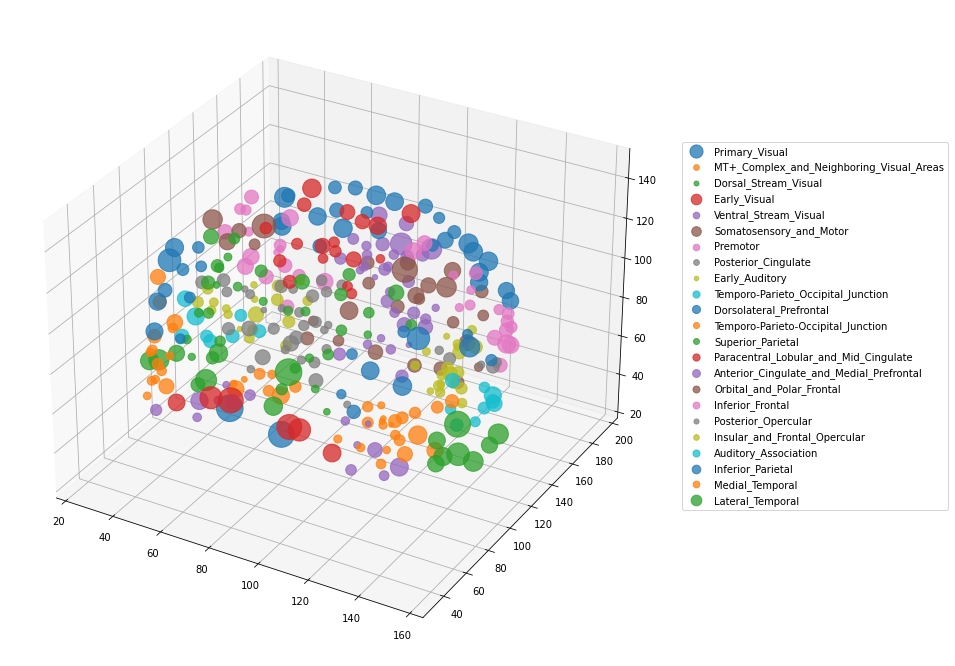

In [7]:
# Colour code the nodes in accordance to each collection
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(projection='3d')

# Plot different colours based on labels:
collectionNames = cortexNames
collectionInds = cortexInds

for k in range(len(collectionNames)):
    inds = collectionInds[k]
    ax.scatter3D(X[inds], Y[inds], Z[inds], s=rads[inds], alpha=0.75)
    
ax.legend(collectionNames, loc='upper right', markerscale=0.5, bbox_to_anchor=(1.45,0.8))

# Configure parameters

In [8]:
# Euclidean distance matrix
dists = spatial.distance.cdist(coords, coords)

# Pairwise kernel function (vary this)
Kfun = lambda i,j, gamma: np.abs(deg[i] - deg[j])**gamma

# Pairwise probability function
Prob = lambda i,j, eta, gamma: dists[i,j]**eta * Kfun(i,j,gamma)


# Pre-liminary plots

The goal here is to loosely determine the distribution of the DTI values. We suspect that it approximates the alpha distribution as a ratio with distance.

In [9]:
# Make cdf
eps = 1e-06
cdfDict = {}
connList = []
arrNumConns = np.zeros((N,N))

numPatients = arrStructs.shape[0]

for i in range(N):
    for j in range(N):
        arrEntry = arrStructs[:,i,j]
        arrRatio = 10**3 * arrEntry / (dists[i,j] + eps)
        arrRatioSort = np.sort(arrRatio) # Increasing order array
        cdfDict[(i,j)] = arrRatioSort # x-values for the cdf plot
        nonZeros = np.nonzero(arrRatio)
        numConns = nonZeros[0].size
        connList.append(numConns)
        arrNumConns[i,j] = numConns

Text(0.5, 1.0, 'Histogram counting edges counting existing connections among patients')

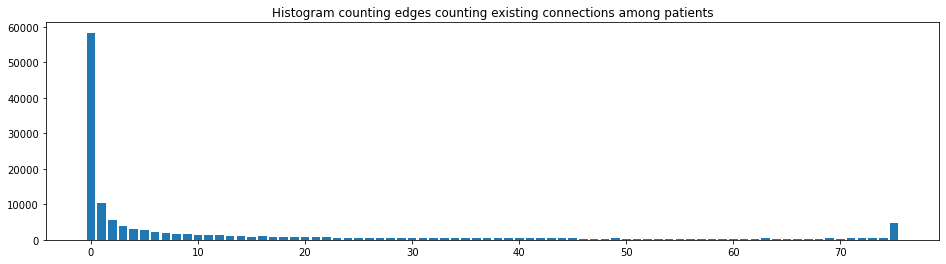

In [10]:
# Histogram
yhist, xhist = np.histogram(connList, bins=numPatients, range=(0, numPatients))
fig, ax = plt.subplots(1, figsize=(16,4))
ax.bar(xhist[0:-1], yhist)
ax.set_title('Histogram counting edges counting existing connections among patients')

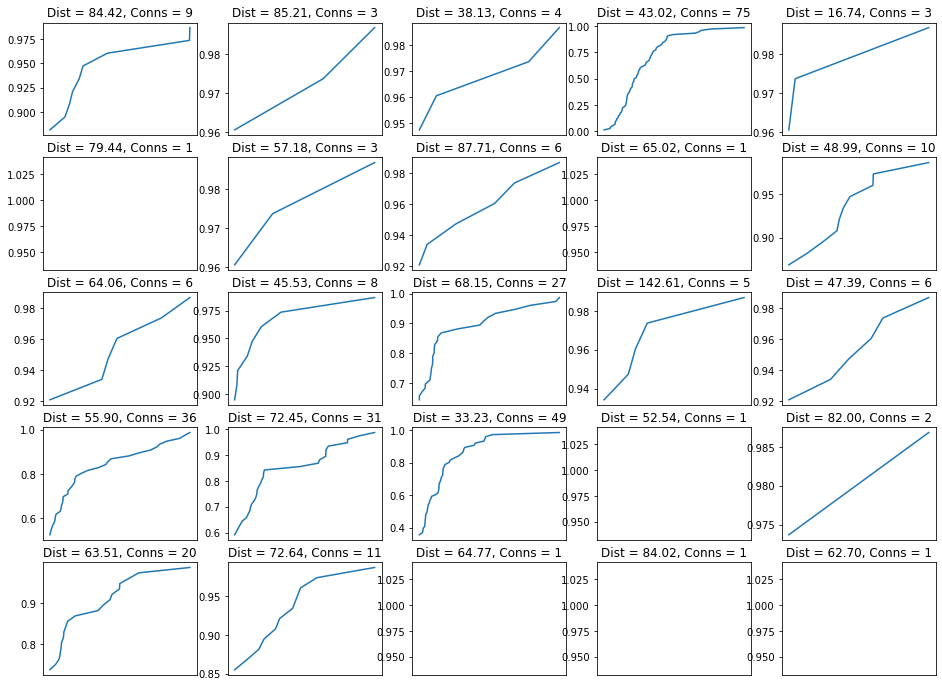

In [17]:
# Indices where there are >0% and <100% connections:
indsPartialConns = np.where((arrNumConns > 0) * (arrNumConns < numPatients))
# Plot random histograms:
nrows = 5
ncols = 5
numPartialConns = indsPartialConns[0].size
indsPlot = np.random.choice(numPartialConns, size=nrows*ncols) # Sample from indices with partial connections

fig, ax = plt.subplots(nrows,ncols, figsize=(16,12))
yarr = np.arange(numPatients) / numPatients
n = 0

for k in range(nrows):
    for l in range(ncols):
        indP = indsPlot[n] # Sampled index to plot
        ind_i = indsPartialConns[0][indP]
        ind_j = indsPartialConns[1][indP]
        n += 1
        xarr = cdfDict[(ind_i, ind_j)]
        
        dist_ij = dists[ind_i, ind_j]
        numConn = arrNumConns[ind_i, ind_j]
        # Remove all zeroes in xarr of cdf:
        indNon0 = np.min(np.where(xarr > 0))
        ax[k,l].plot(xarr[indNon0:], yarr[indNon0:])
        ax[k,l].set_title(f'Dist = %.2f, Conns = %d' % (dist_ij, numConn))
        ax[k,l].set_xticks([])

(36,)


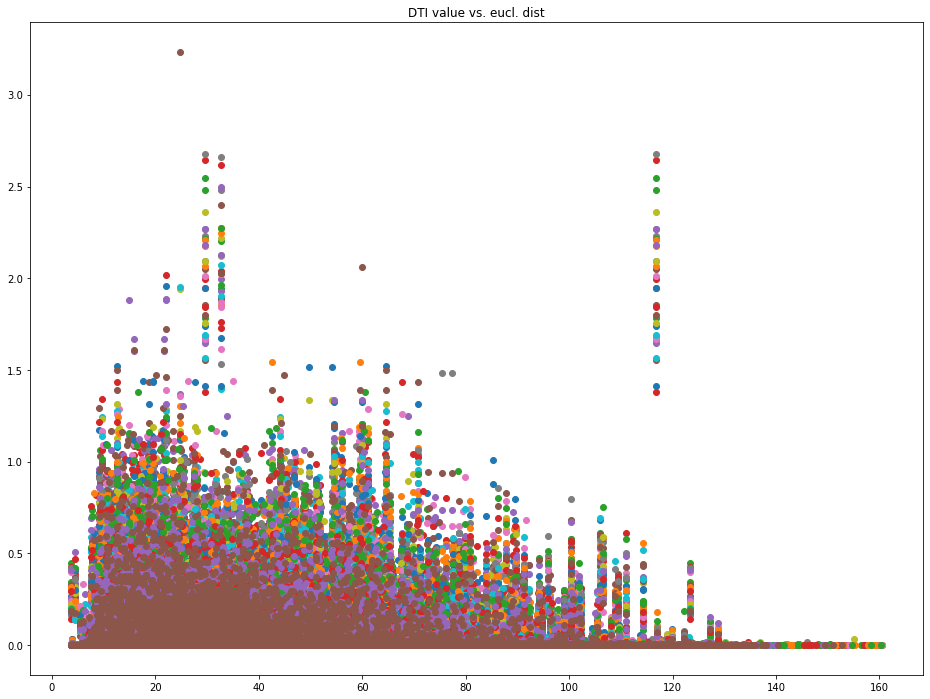

In [12]:
# Obtain coordinates with distance and healthy structure:
arrDistsAll = np.array([])
arrDTIAll = np.array([])

indsHealthy = np.where(arrLabels == 0)[0]
arrDist1d = np.reshape(dists, -1)
indD = np.where(arrDist1d > 0)[0]

fig, ax = plt.subplots(1, figsize=(16,12))
ax.set_title('DTI value vs. eucl. dist')

print(indsHealthy.shape)
for i in range(len(indsHealthy)):
    ind = indsHealthy[i]
    arrStruct = arrStructs[ind]
    arrStruct1d = np.reshape(arrStruct, -1)
    indS = np.where(arrStruct1d > 0)[0]
    indNon0 = np.intersect1d(indD, indS)

    ax.scatter(arrDist1d[indNon0], arrStruct1d[indNon0])



In [13]:
# Obtain indices i,j where there are connections 0% and 100% of the time
# Randomly sample from the indices where connections exist partially for each patient, and do a two-part sampling (one for connection, the other for strength)
# There appears to be a loose correlation between cdf steepness (of a gamma distribution) and the distance?
# Looks for other factors, such as clustering.
# Perhaps the number of neighbouring connections as well? Volume of the region as well.
# Mimic the paper for determining connections
# Use the KS-test with estimated parameters for various distributions.
# Samples are connections with a large number of non-zero values
# Determine percentage of existing connections for healthy + non-healthy